In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('https://www.dropbox.com/s/5cgteeozyccaf6n/weatherHistory_training.csv?dl=1')
print(df_train.shape)
df_train.head(15)

(70000, 2)


,Formatted Date,Temperature (C)
0,2006-01-01 00:00:00.000 +0100,0.577778
1,2006-01-01 01:00:00.000 +0100,1.161111
2,2006-01-01 02:00:00.000 +0100,1.666667
3,2006-01-01 03:00:00.000 +0100,1.711111
4,2006-01-01 04:00:00.000 +0100,1.183333
5,2006-01-01 05:00:00.000 +0100,1.205556
6,2006-01-01 06:00:00.000 +0100,2.222222
7,2006-01-01 07:00:00.000 +0100,2.072222
8,2006-01-01 08:00:00.000 +0100,2.200000
9,2006-01-01 09:00:00.000 +0100,2.733333


In [ ]:
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, label_name):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = []   # Khai báo list dùng để lưu trữ các y

    window_size = input_size + label_size # Tính kích thước của window

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - window_size 
    
    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size # Tính chỉ mục kết thúc của X
        label_start_idx = idx + window_size - label_size # Tính chỉ mục bắt đầu của y

        feature = df[idx:feature_end_idx] # Lấy X
        label = df[label_name][label_start_idx:(idx+window_size)] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [ ]:
INPUT_SIZE = 48 # Dùng `input_size` giờ trước
LABEL_SIZE = 6  # Để dự đoán nhiệt độ trong `label_size` giờ
BATCH_SIZE = 32
FEATURE_FINAL = ['Temperature (C)']
label_name = 'Temperature (C)'

In [ ]:
X_train, y_train = slicing_window(df_train[FEATURE_FINAL], 
                                  df_start_idx=0,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  label_name = label_name)

print(X_train.shape)
print(y_train.shape)

(69946, 48, 1)
(69946, 6)


In [2]:
df_test = pd.read_csv('https://www.dropbox.com/s/cq8fypkq0w6728o/weatherHistory_testing.csv?dl=1')
df_test.head(15)

,Formatted Date,Temperature (C)
0,2013-12-25 16:00:00.000 +0100,7.777778
1,2013-12-25 17:00:00.000 +0100,7.194444
2,2013-12-25 18:00:00.000 +0100,7.127778
3,2013-12-25 19:00:00.000 +0100,7.111111
4,2013-12-25 20:00:00.000 +0100,7.066667
5,2013-12-25 21:00:00.000 +0100,6.600000
6,2013-12-25 22:00:00.000 +0100,6.438889
7,2013-12-25 23:00:00.000 +0100,5.972222
8,2013-12-26 00:00:00.000 +0100,5.416667
9,2013-12-26 01:00:00.000 +0100,5.333333


In [ ]:
X_test, y_test = slicing_window(df_test[FEATURE_FINAL], 
                                  df_start_idx=0,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  label_name = label_name)

print(X_test.shape)
print(y_test.shape)

(26399, 48, 1)
(26399, 6)


In [ ]:
import tensorflow as tf

# Khởi tạo tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model and train

In [ ]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization(axis=-1)
normalize_layer.adapt(np.vstack((X_train, X_test)))

In [ ]:
model = tf.keras.Sequential([tf.keras.Input(shape=(INPUT_SIZE, 1), name='input_layer'), 
                             normalize_layer,  
                             tf.keras.layers.LSTM(32),  
                             tf.keras.layers.Dense(LABEL_SIZE)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 1)            3         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 4,553
Trainable params: 4,550
Non-trainable params: 3
_________________________________________________________________


In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 20
LR = 1e-3

# Cấu hình một số thông tin cho mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.MeanSquaredError())
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/20
2186/2186 [==============================] - 25s 7ms/step - loss: 68.5772 - val_loss: 40.8127
Epoch 2/20
2186/2186 [==============================] - 13s 6ms/step - loss: 19.6406 - val_loss: 18.4384
Epoch 3/20
2186/2186 [==============================] - 13s 6ms/step - loss: 10.7134 - val_loss: 9.6566
Epoch 4/20
2186/2186 [==============================] - 14s 6ms/step - loss: 5.3203 - val_loss: 7.4101
Epoch 5/20
2186/2186 [==============================] - 14s 6ms/step - loss: 4.4588 - val_loss: 6.4479
Epoch 6/20
2186/2186 [==============================] - 13s 6ms/step - loss: 4.1712 - val_loss: 5.6378
Epoch 7/20
2186/2186 [==============================] - 13s 6ms/step - loss: 3.9403 - val_loss: 5.2739
Epoch 8/20
2186/2186 [==============================] - 14s 6ms/step - loss: 3.8109 - val_loss: 5.1923
Epoch 9/20
2186/2186 [==============================] - 13s 6ms/step - loss: 3.6972 - val_loss: 4.9503
Epoch 10/20
2186/2186 [==============================] - 13s 6ms/ste

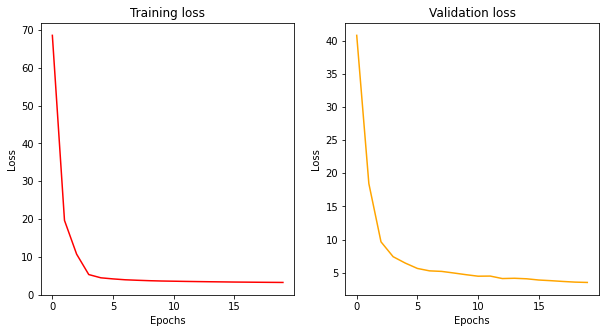

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']# Đọc thông tin loss trên tập train
val_loss = history.history['val_loss'] # Đọc thông tin loss trên tập val

plt.figure(figsize=(10, 5)) # Cài đặt kích thước khung ảnh

plt.subplot(1, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(1, 2, 2) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='orange') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.show() # Hiển thị 2 khung ảnh nhỏ